<a href="https://colab.research.google.com/github/sayak-coding/Chest_X-Ray_Medical_Diagnosis_with_Deep_Learning/blob/main/Chest_X_Ray_Medical_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#import modules

import numpy as np # library for linear algebra
import pandas as pd # library for dealing with data frame
import seaborn as sns # library for visualization of data
import matplotlib.pyplot as plt # library for visualization of data
import matplotlib.image as mpimg # import matplotlib.image as mpimg
from sklearn.metrics import roc_curve # use it to compute the Receiver Operating Characteristic (ROC) curve
from sklearn.metrics import roc_auc_score # use it to compute the Area Under the ROC Curve (AUC-ROC) score

from keras.preprocessing.image import ImageDataGenerator # allows your model to receive new variations of the images at each epoch
from keras.applications.densenet import DenseNet121 # DenseNet architectures have demonstrated excellent performance on various image classification tasks
from keras.layers import Dense, GlobalAveragePooling2D # applying global average pooling operation for spatial data
from keras.models import Model # It provides a convenient way to define and train neural network models
from keras import backend as K # access backend-specific functionality within a Keras model or custom layer

from keras.models import load_model # use it for inference or further training without having to retrain the model from scratch

import tensorflow as tf # building and training neural networks, working with tensors
tf.compat.v1.disable_eager_execution() # to disable eager execution and enable the graph mode

import cv2 # use its functionalities for image and video processing tasks
from tensorflow.keras.models import Model # use it to create and work with Keras models
from tensorflow.keras.preprocessing.image import load_img, img_to_array # to load an image from a file
from tensorflow.keras.applications.densenet import preprocess_input # use it to preprocess input images for DenseNet models

import os # a way to interact with the operating system in a platform-independent manner

In [2]:
 # mount with google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# location of train data set
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/train-small.csv")

# location of validation data set
valid_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/valid-small.csv")

# location of test data set
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/test.csv")

In [4]:
# showing the train data set

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [5]:
# showing the train data set

valid_df.head(5)

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [6]:
# showing the train data set

test_df.head(5)

,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [7]:
# denote the labels of the disease,there are 14 labels
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [8]:
# function for checking the data leakage
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col]) # set of patient id of a data frame
    df2_patients_unique = set(df2[patient_col]) # set of patient id of another data frame

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique) # taking inetrsection of two data set

    # leakage contains true if there is patient overlap, otherwise false.
    if patients_in_both_groups:
        leakage = True # boolean (true if there is at least 1 patient in both groups)
    else:
        leakage = False


    return leakage

In [9]:
# checking our function is working good or not

print("test case 1") # test case 1
df1 = pd.DataFrame({'patient_id': [0, 1, 2]}) # patient id of data set 1
df2 = pd.DataFrame({'patient_id': [2, 3, 4]}) # patient id of data set 2
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}") # checking the leakage
print("-------------------------------------")
print("test case 2") # test case 2
df1 = pd.DataFrame({'patient_id': [0, 1, 2]}) # patient id of data set 1
df2 = pd.DataFrame({'patient_id': [3, 4, 5]}) # patient id of data set 2
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}") # checking the leakage

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


In [10]:
# check the data leakage between train and test data set
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))

#check the data leakage between validation set and test data set
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [11]:
# generates a data generator for training a model using images
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [12]:
# generates data generators for the validation and test sets
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

Display Random Images


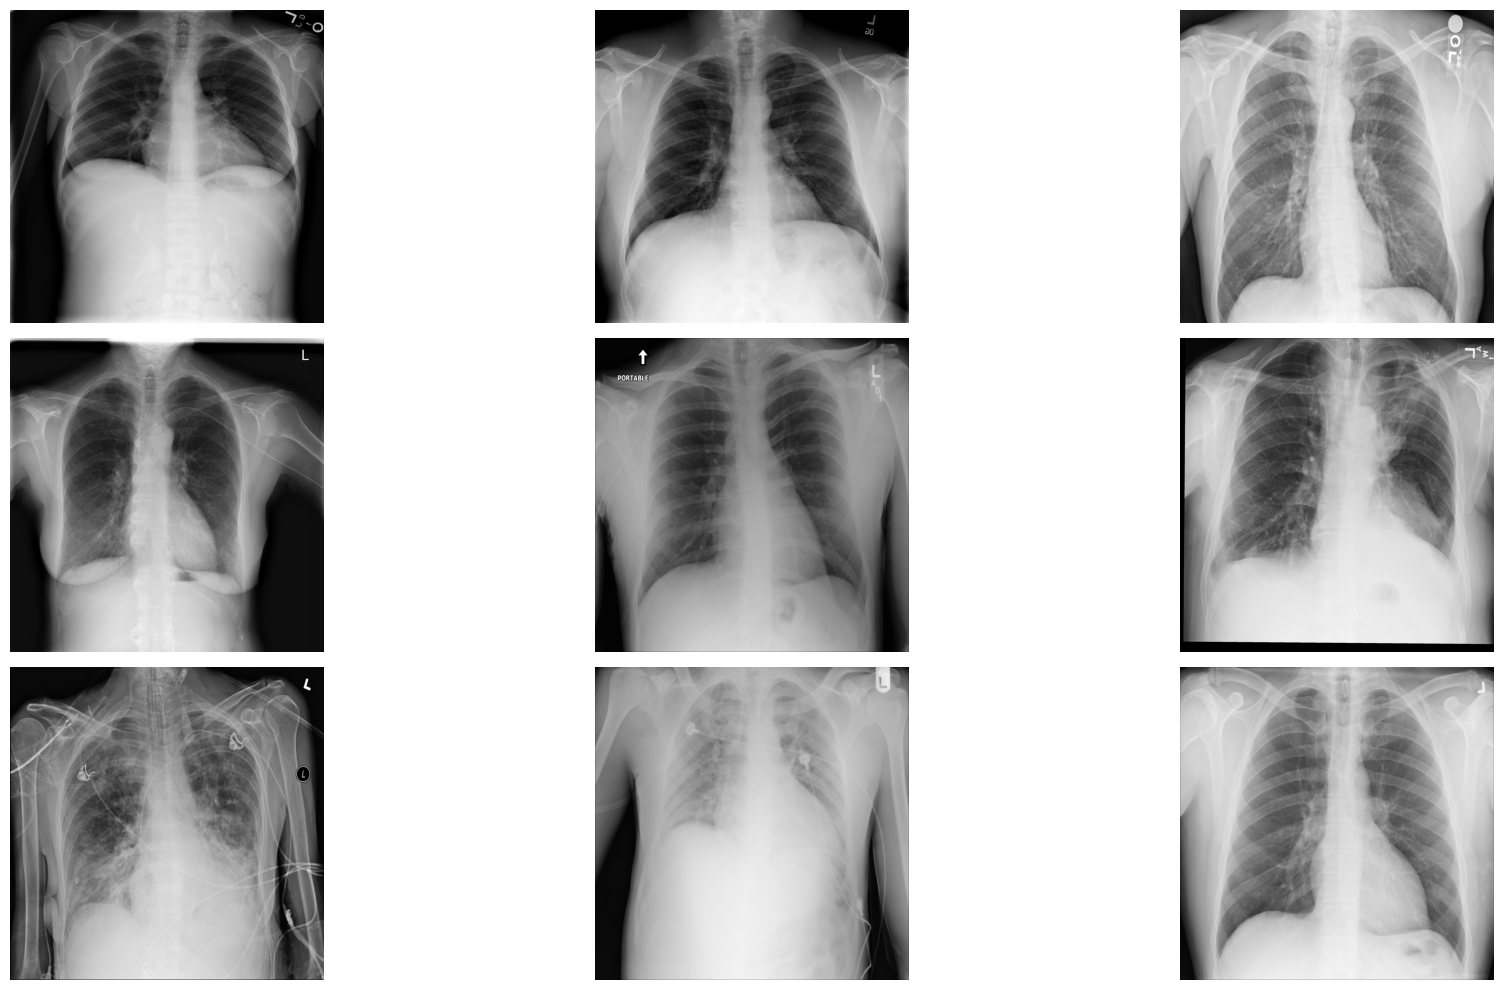

In [13]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/images-small'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


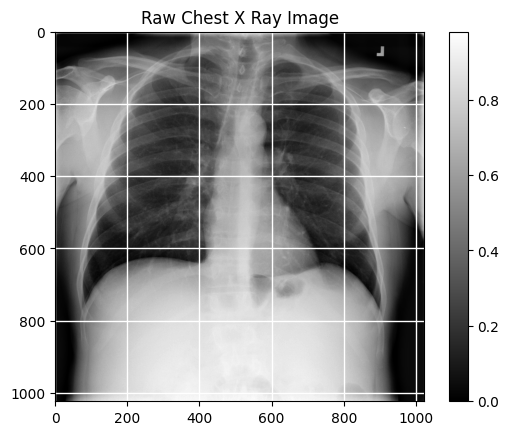

In [14]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

In [15]:
# IMAGE DIRECTORY FOR TEST , TRAIN, AND VALIDATION SET
IMAGE_DIR = img_dir

train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


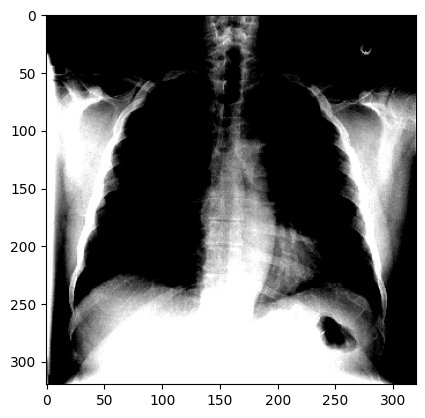

In [16]:
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0]);

<ipython-input-17-30006afcf9d9>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
<ipython-input-17-30006afcf9d9>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


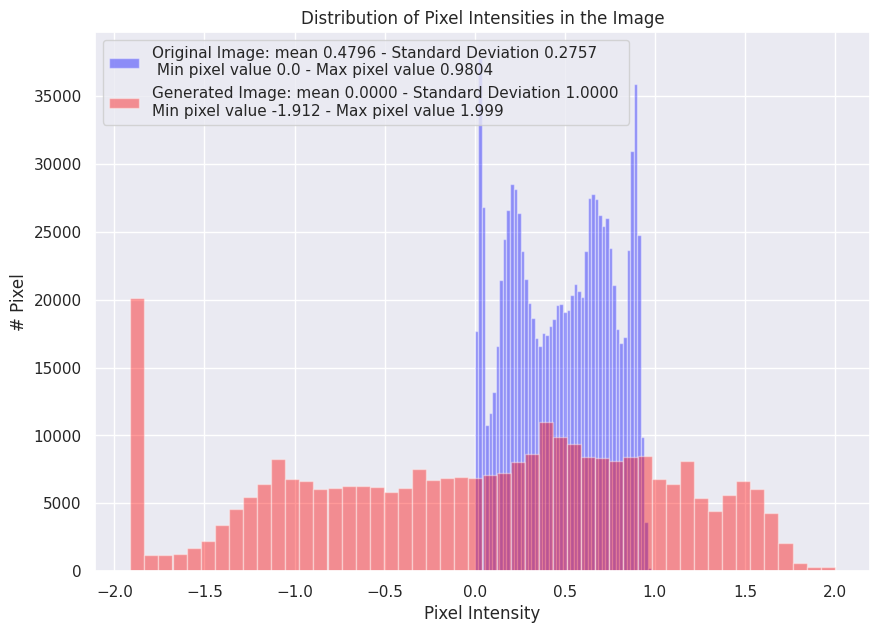

In [17]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(),
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue',
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}',
             color='red',
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

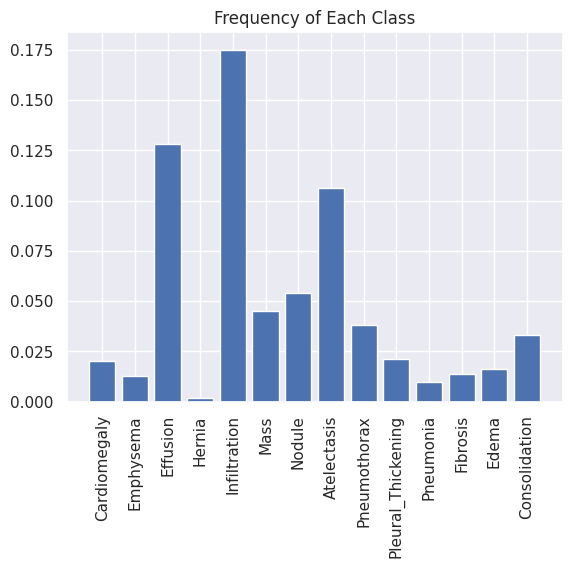

In [18]:
# frequency of each levels

plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [19]:
# computes the class frequencies for binary labels
def compute_class_freqs(labels):

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [20]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [21]:
# compute frequencies for our training data
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

<ipython-input-22-5bc3ecfef25d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


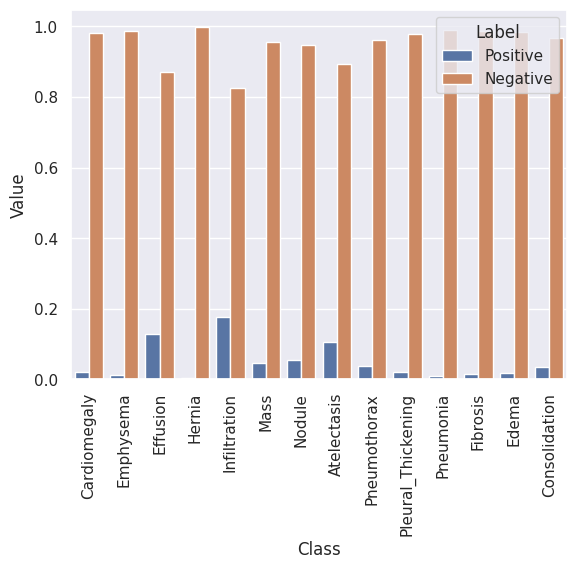

In [22]:
# visualize these two contribution ratios next to each other for each of the pathologies
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [23]:
# we will be balancing the contribution of positive and negative labels
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

<ipython-input-24-0f2369575b9c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


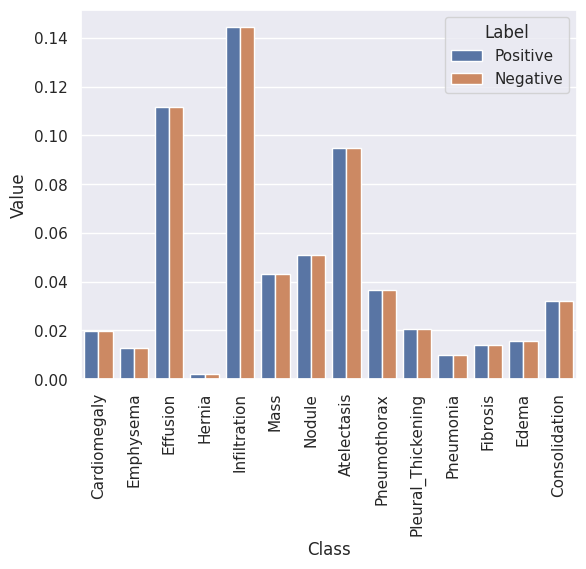

In [24]:
# verify this by graphing the two contributions next to each other again
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [25]:
# Return weighted loss function given negative weights and positive weights
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

#  Return weighted loss value
    def weighted_loss(y_true, y_pred):

        # initialize loss to zero
        loss = 0.0

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon)
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss

    return weighted_loss

In [26]:
# test our function with some simple cases
sess = K.get_session()
with sess.as_default() as sess:
    print("Test example:\n")
    y_true = K.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
    print("y_true:\n")
    print(y_true.eval())

    w_p = np.array([0.25, 0.25, 0.5])
    w_n = np.array([0.75, 0.75, 0.5])
    print("\nw_p:\n")
    print(w_p)

    print("\nw_n:\n")
    print(w_n)

    y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1:\n")
    print(y_pred_1.eval())

    y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2:\n")
    print(y_pred_2.eval())

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=1)

    print("\nIf we weighted them correctly, we expect the two losses to be the same.")
    L1 = L(y_true, y_pred_1).eval()
    L2 = L(y_true, y_pred_2).eval()
    print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
    print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = 0.0000


In [27]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
# import h5py

In [29]:
# model.load_weights("/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/pretrained_model.h5")

In [30]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator)) # generate predictions for a test dataset

<ipython-input-30-591bc4586ab7>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator)) # generate predictions for a test dataset
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [31]:
# generates ROC (Receiver Operating Characteristic) curves and calculates the corresponding AUC (Area Under the Curve) values for each label
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

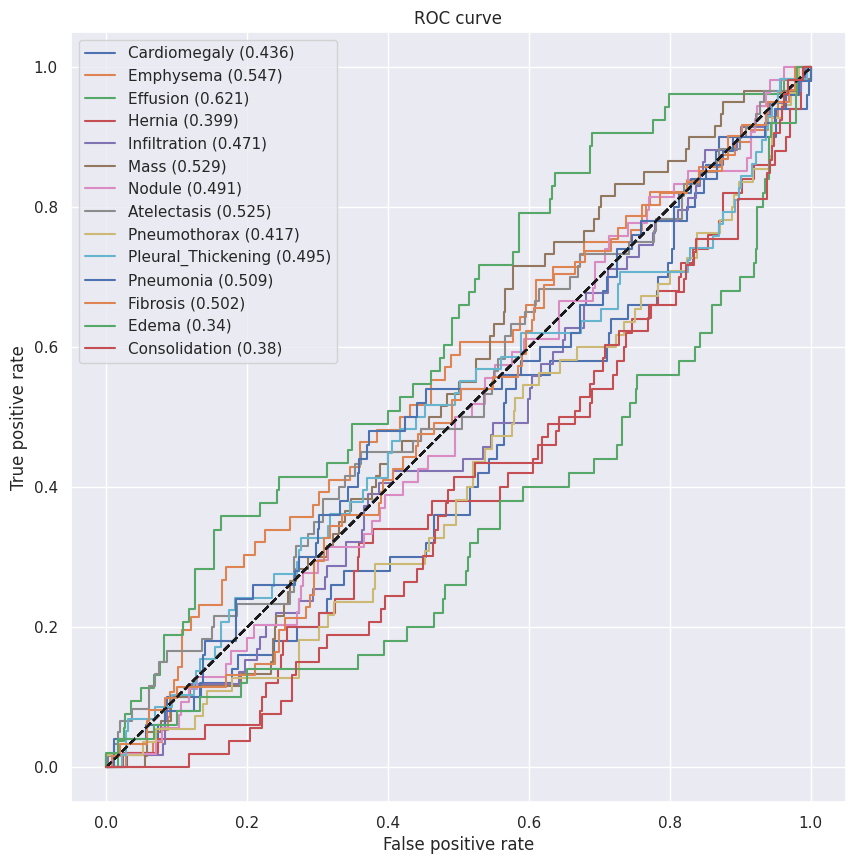

In [32]:
# calling the get_roc_curve function with the appropriate arguments
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [33]:
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/train-small.csv")
# IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/images-small"

# # only show the labels with top 4 AUC
# labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [34]:
# # from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.preprocessing.image import load_img

In [50]:
# generates Grad-CAM (Gradient-weighted Class Activation Mapping) visualizations for a given image using a pre-trained model
def compute_gradcam(model, image_path, image_dir, df, labels, labels_to_show):
    # Load the image and preprocess it
    #image = load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    # image_array = img_to_array(image)
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    # image_array = tf.expand_dims(image_array, axis=0)
    # processed_image = preprocess_input(image_array)
    processed_image = tf.keras.applications.vgg16.preprocess_input(image_array)

    # Retrieve the target layer for Grad-CAM
    target_layer = model.get_layer('conv5_block16_concat')  # Replace with the desired layer

    # Create a new model that outputs the target layer's activations and the model's predictions
    cam_model = Model(inputs=model.input, outputs=[target_layer.output, model.output])

    # Compute the gradients of the target layer's output with respect to the model's final predictions
    with tf.GradientTape() as tape:
        target_layer_output, model_output = cam_model(processed_image)
        predicted_class = np.argmax(model_output[0])
        loss = model_output[:, predicted_class]

    gradients = tape.gradient(loss, target_layer_output)
    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

    # Multiply each activation map with its corresponding gradient value
    activations = target_layer_output[0]
    weighted_activations = activations * pooled_gradients[:, tf.newaxis, tf.newaxis]

    # Average the weighted activation maps along the channel dimension
    heatmap = tf.reduce_mean(weighted_activations, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Convert the heatmap to a NumPy array
    heatmap = heatmap.numpy().astype(np.float32)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (image.width, image.height))
    heatmap = np.uint8(255 * heatmap)

    # Apply a colormap to the heatmap
    colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the colormap onto the original image
    image_array = np.uint8(255 * preprocess_input(image_array)[0])
    heatmap_overlay = cv2.addWeighted(colormap, 0.5, image_array, 0.5, 0)

    # Display the original image, heatmap, and heatmap overlay
    cv2.imshow('Original Image', image_array)
    cv2.imshow('Heatmap', heatmap)
    cv2.imshow('Heatmap Overlay', heatmap_overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [36]:
# denote the labels of the disease,there are 14 labels
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [37]:
# Usage example
IMAGE_DIR = img_dir
df = test_df  # DataFrame containing image filenames and labels

labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]# List of labels to display in Grad-CAM visualization

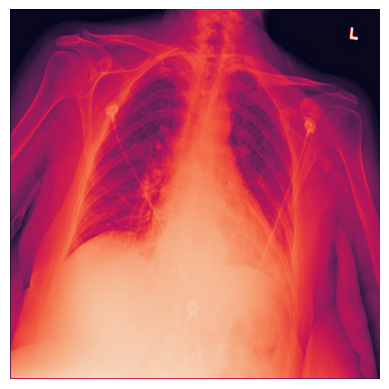

In [39]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Capstone project/DL - Chest_X-Ray_Medical_Diagnosis/Chest-X-Ray-Medical-Diagnosis/nih/images-small/00021463_005.png'  # Specify the path to the image file
image = mpimg.imread(image_path)  # Load the image
plt.imshow(image)  # Display the image
plt.axis('off')  # Optional: Turn off the axis labels
plt.show()  # Show the image


In [52]:
# Call the compute_gradcam function
compute_gradcam(model, image_path, IMAGE_DIR, df, labels, labels_to_show)